**Import packages**

In [113]:
import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt # Matlab-style plotting
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics

import math
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

# Gathering Data

**Importing *train* and *test* datasets**

In [114]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

**Creating a copy of the train and test datasets**

In [115]:
c_test  = test.copy()
c_train  = train.copy()

**Getting information about train dataset**

In [116]:
c_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Getting information about test dataset**

In [117]:
c_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Preparing The Data

In [118]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(c_train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = c_train['Id']
test_ID = c_test['Id']

# Drop the  'Id' colum
c_train.drop("Id", axis = 1, inplace = True)
c_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(c_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(c_test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


*Am eliminat coloana 'Id', deoarece nu este necesara pentru procesul de predictie.*

**Outliers**

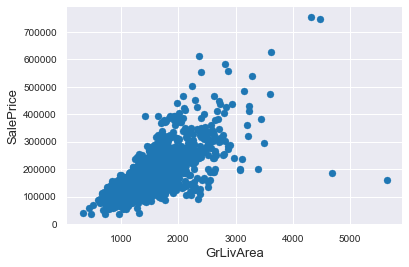

In [119]:
fig, ax = plt.subplots()
ax.scatter(x = c_train['GrLivArea'], y = c_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

*Vom elimina cele doua valori din dreapta, deoarece perturba procesul (acopera zone extrem de mari la preturi foarte scazute).*

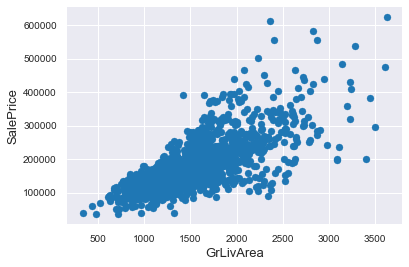

In [120]:
#Deleting outliers
c_train = c_train.drop(c_train[(c_train['GrLivArea']>4000) & (c_train['SalePrice']<800000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(c_train['GrLivArea'], c_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

*Alti posibili outlieri nu vor fi eliminati pentru a nu afecta prea mult antrenarea modelului, intrucat ar putea exista outlieri si in datele de test.*

## Target variable analysis


 mu = 180151.23 and sigma = 76670.25



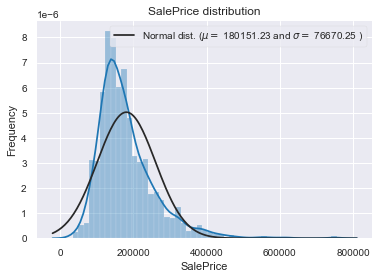

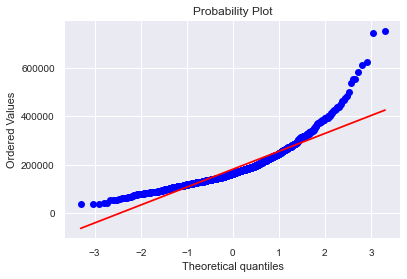

In [121]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(c_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

*Aceasta denaturare are loc, deoarece exista outlieri care nu pot fi filtrati, deoarece acestia sunt importanti pentru model.*

**Log-transformation of the target variable**

*Trebuie sa transformam variabila tinta pentru a avea o distributie "mai normala".*


 mu = 12.02 and sigma = 0.40



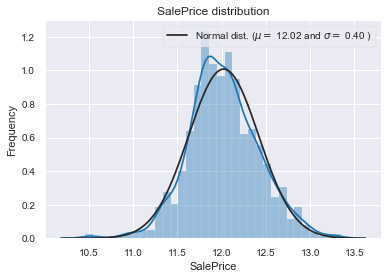

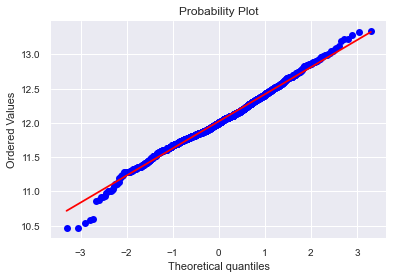

In [122]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
c_train["SalePrice"] = np.log1p(c_train["SalePrice"])

#Check the new distribution 
sns.distplot(c_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(c_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(c_train['SalePrice'], plot=plt)
plt.show()

In [123]:
# #skewness and kurtosis
# print("Skewness: %f" % df['SalePrice'].skew())
# print("Kurtosis: %f" % df['SalePrice'].kurt())

## Features engineering

**Concat Train and Test datasets**

In [124]:
c_train['train']  = 1
print("c_train size is : {}".format(c_train.shape))
c_test['train']  = 0
print("c_test size is : {}".format(c_test.shape))
df = pd.concat([c_train, c_test], axis=0,sort=False)
print("df size is : {}".format(df.shape))

c_train size is : (1456, 81)
c_test size is : (1459, 80)
df size is : (2915, 81)


In [125]:
# df.info()

**Pandas Profile Report**

In [126]:
# import pandas_profiling
# profile = df.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="pandas_profiling.html")

## Data preprocessing

**Imputing missing values**

In [127]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageCond,81,0.055
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageFinish,81,0.055


In [128]:
df = df.drop(['Alley','PoolQC','Fence','MiscFeature', 'FireplaceQu'],axis=1)

**Selecting the categorical & the numerical features**

In [129]:
object_columns_df = df.select_dtypes(include=['object'])
numerical_columns_df =df.select_dtypes(exclude=['object'])

**Categorical Features:**

In [130]:
object_columns_df.dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

**Deeling with categorical feature**

In [131]:
#Number of null values in each feature
null_counts = object_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
MSZoning           4
Street             0
LotShape           0
LandContour        0
Utilities          2
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
RoofStyle          0
RoofMatl           0
Exterior1st        1
Exterior2nd        1
MasVnrType        24
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
KitchenQual        1
Functional         2
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PavedDrive         0
SaleType           1
SaleCondition      0
dtype: int64


We will fill -- **BsmtQual (Height of the basement), BsmtCond (General condition of the basement), BsmtExposure (Walkout or garden level basement walls), BsmtFinType1 (Quality of basement finished area), BsmtFinType2 (Quality of second finished area (if present)), ** -- with "None".

We will fill the rest of features with the most frequent value (using its own most frequent value).

In [132]:
object_columns_df = object_columns_df.drop(['Utilities', 'GarageType','GarageFinish','GarageQual','GarageCond'],axis=1)

In [133]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
object_columns_df[columns_None]= object_columns_df[columns_None].fillna('None')

In [134]:
columns_with_lowNA = ['MSZoning','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
#fill missing values for each column (using its own most frequent value)
object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])

In [135]:
# #Number of null values in each feature
# null_counts = object_columns_df.isnull().sum()
# print("Number of null values in each column:\n{}".format(null_counts))

**Numerical Features:**

In [136]:
numerical_columns_df.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
train              int64
dtype: object

**Deeling with numerical feature**

In [137]:
#Number of null values in each feature
null_counts = numerical_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64


In [138]:
df = df.drop(['GarageYrBlt','LowQualFinSF','MiscVal','BsmtFinSF2','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea'],axis=1)

In [139]:
for col in ('GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

*Intrucat fiecare strada care este conectata la proprietatea casei are cel mai probabil o zona similara cu alte proprietati din cartierul sau, putem completa valorile lipsa cu mediana.*

In [140]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [141]:
print(numerical_columns_df["LotFrontage"].median())

68.0


So we will fill the Lot frontage (Linear feet of street connected to property) with 68.

In [142]:
numerical_columns_df['LotFrontage'] = numerical_columns_df['LotFrontage'].fillna(68)

Fill the rest of columns with 0

In [143]:
numerical_columns_df= numerical_columns_df.fillna(0)

In [144]:
# #Number of null values in each feature
# null_counts = numerical_columns_df.isnull().sum()
# print("Number of null values in each column:\n{}".format(null_counts))

**Label Encoding some categorical variables that may contain information in their ordering set**

In [145]:
from sklearn.preprocessing import LabelEncoder
cols = ('BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

# shape        
print('Shape df: {}'.format(df.shape))

Shape df: (2915, 68)


**Now we will create some new features**

In [146]:
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count   2915.000
mean      36.522
std       30.335
min       -1.000
25%        7.000
50%       35.000
75%       55.000
max      136.000
Name: Age_House, dtype: float64

In [147]:
Negatif = numerical_columns_df[numerical_columns_df['Age_House'] < 0]
Negatif

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House
1089,20,128.000,39290,10,5,2008,2009,1224.000,4010.000,0.000,...,0,0,0,0,17000,10,2007,0.000,0,-1


Like we see here that the minimun is -1 ???
It is strange to find that the house was sold in 2007 before the YearRemodAdd 2009.
So we decide to change the year of sold to 2009

In [148]:
numerical_columns_df.loc[numerical_columns_df['YrSold'] < numerical_columns_df['YearBuilt'],'YrSold' ] = 2009
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count   2915.000
mean      36.522
std       30.334
min        0.000
25%        7.000
50%       35.000
75%       55.000
max      136.000
Name: Age_House, dtype: float64

TotalBsmtBath : Sum of : BsmtFullBath and 1/2 BsmtHalfBath

TotalBath : Sum of : FullBath and 1/2 HalfBath

TotalSA : Sum of : 1stFlrSF and 2ndFlrSF and basement area </font>

In [149]:
numerical_columns_df['TotalBsmtBath'] = numerical_columns_df['BsmtFullBath'] + numerical_columns_df['BsmtFullBath']*0.5
numerical_columns_df['TotalBath'] = numerical_columns_df['FullBath'] + numerical_columns_df['HalfBath']*0.5 
numerical_columns_df['TotalSA']=numerical_columns_df['TotalBsmtSF'] + numerical_columns_df['1stFlrSF'] + numerical_columns_df['2ndFlrSF']

In [150]:
numerical_columns_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,60,65.000,8450,7,5,2003,2003,196.000,706.000,0.000,...,0,0,2,2008,12.248,1,5,1.500,2.500,2566.000
1,20,80.000,9600,6,8,1976,1976,0.000,978.000,0.000,...,0,0,5,2007,12.109,1,31,0.000,2.000,2524.000
2,60,68.000,11250,7,5,2001,2002,162.000,486.000,0.000,...,0,0,9,2008,12.317,1,7,1.500,2.500,2706.000
3,70,60.000,9550,7,5,1915,1970,0.000,216.000,0.000,...,0,0,2,2006,11.849,1,91,1.500,1.000,2473.000
4,60,84.000,14260,8,5,2000,2000,350.000,655.000,0.000,...,0,0,12,2008,12.429,1,8,1.500,2.500,3343.000


**Skewed features**

In [151]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
LotArea,13.124
LandSlope,4.971
KitchenAbvGr,4.299
BsmtHalfBath,3.941
MasVnrArea,2.588
OpenPorchSF,2.529
WoodDeckSF,1.848
1stFlrSF,1.253
LotFrontage,1.093
GrLivArea,0.978


**Box Cox Transformation of (highly) skewed features**

In [152]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #df[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)
    
#df[skewed_features] = np.log1p(df[skewed_features])

There are 45 skewed numerical features to Box Cox transform


In [153]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
LandSlope,4.528
BsmtHalfBath,3.797
KitchenAbvGr,3.696
MasVnrArea,0.624
HalfBath,0.595
BsmtFullBath,0.441
2ndFlrSF,0.330
Fireplaces,0.286
HeatingQC,0.285
WoodDeckSF,0.226


**Getting dummy categorical features**

In [154]:
df = pd.get_dummies(df)
print(df.shape)

(2915, 215)


# PANDAS

In [167]:
# import pandas_profiling
# profile = df.profile_report(title='Pandas Profiling Report 2')
# profile.to_file(output_file="pandas_profiling_2.html")

# Modeling

**Models**

In [156]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [157]:
sum(data.isnull().sum() != 0)

0

In [158]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50, test_size=.2)

**LightGBM**

In [160]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train, y_train)
Y_pred_lgb = model_lgb.predict(X_test)
# Y_pred_test = model_lgb.predict(test_data)

print ('\nRMSLE is: \n', np.sqrt(mean_squared_log_error(y_test, Y_pred_lgb)))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

RMSLE is: 
 0.01077711274996348


# Prediction

In [162]:
subm = pd.DataFrame()
subm['Id'] = test.Id
feats = test.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()
Y_pred_lgb = model_lgb.predict(feats)
final_pred = np.exp(Y_pred_lgb)
print ("Original predictions are: \n", Y_pred_lgb[:5], "\n")
print ("Final predictions are: \n", final_pred[:5])

Original predictions are: 
 [11.73369066 11.9333825  12.15735384 12.15172116 12.10683061] 

Final predictions are: 
 [124703.05892805 152265.73023906 190489.78222985 189419.83117652
 181104.70294075]


In [163]:
subm['SalePrice'] = final_pred
subm.head()

,Id,SalePrice
0,1461,124703.059
1,1462,152265.730
2,1463,190489.782
3,1464,189419.831
4,1465,181104.703


In [165]:
# subm.to_csv('submission_rmsle_5.csv', index=False)

**Linear Regression**

In [ ]:
# from sklearn import linear_model
# lr = linear_model.LinearRegression()
# model = lr.fit(X_train, y_train)
# predictions = model.predict(X_test)
# print ("R^2 is: \n", model.score(X_test, y_test))

# from sklearn.metrics import mean_squared_log_error
# print ('RMSLE is: \n', np.sqrt(mean_squared_log_error( y_test, predictions )))

In [ ]:
# actual_values = y_test
# plt.scatter(predictions, actual_values, alpha=.7,
#             color='b') #alpha helps to show overlapping data
# plt.xlabel('Predicted Price')
# plt.ylabel('Actual Price')
# plt.title('Linear Regression Model')
# plt.show()

In [ ]:
# alpha = 0.0001
# rm = linear_model.Ridge(alpha=alpha)
# ridge_model = rm.fit(X_train, y_train)
# preds_ridge = ridge_model.predict(X_test)

# plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
# plt.xlabel('Predicted Price')
# plt.ylabel('Actual Price')
# plt.title('Ridge Regularization with alpha = {}'.format(alpha))
# overlay = 'R^2 is: {}\nRMSLE is: {}'.format(ridge_model.score(X_test, y_test),np.sqrt(mean_squared_log_error( y_test, predictions )))

# plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
# plt.show()

In [ ]:
# submission = pd.DataFrame()
# submission['Id'] = test.Id
# feats = test.select_dtypes(
#         include=[np.number]).drop(['Id'], axis=1).interpolate()
# predictions = model.predict(feats)
# final_predictions = np.exp(predictions)
# print ("Original predictions are: \n", predictions[:5], "\n")
# print ("Final predictions are: \n", final_predictions[:5])

In [ ]:
# submission['SalePrice'] = final_predictions
# submission.head()

In [ ]:
# submission.to_csv('submission_rmsle_2.csv', index=False)

**Support Vector Regression (SVR)**

In [ ]:
# from sklearn.svm import SVR
# regressor = SVR(kernel='rbf')
# regressor.fit(X_train,y_train)

# y_pred = regressor.predict(X_test)

# print ("R^2 is: \n", regressor.score(X_test, y_test))
# from sklearn.metrics import mean_squared_log_error

# print ('RMSLE is: \n', np.sqrt(mean_squared_log_error( y_test, y_pred )))

**Random Forest Regressor**

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 50)
# rf.fit(X_train,y_train)

# pred = rf.predict(X_test)

# print ("R^2 is: \n", regressor.score(X_test, y_test))
# from sklearn.metrics import mean_squared_log_error

# print ('RMSLE is: \n', np.sqrt(mean_squared_log_error( y_test, pred )))